# Tutorial 2: The `Layout` Object

The `Layout` object is the core building block for defining and analysing different project scenarios.
The `Layout` object contains all of the geometric/geographic information about the placement of project turbines, as well as additional information on the allowable buildable areas, exclusion zones, and site bathymetry.

This object has many useful methods that make carrying out otherwise complex geoprocessing tasks into very simple one-line commands.
This tutorial will cover the creation and manipulation of `Layout` objects.

## 1. Creating a `Layout` Object
The main method to initialise a `Layout` object is to pass it a `Grid`, so make sure to import both `Layout` and `Grid`.

Just like with the `Grid` object, the `Layout` object has a convenience method to plot it in a matplotlib Figure.

(<Figure size 576x432 with 1 Axes>, <AxesSubplot:>)

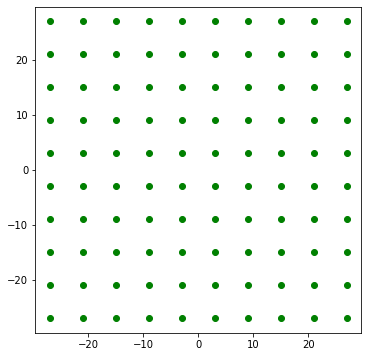

In [17]:
from layowt.grids import Grid
from layowt.layouts import Layout

layout = Layout(Grid())
layout.plot()

## 2. Applying Constraints to a `Layout`
We can create a `Layout` from a `Grid`, but of what use is this to us if it is only recreating the exact same information in a differently named data structure?

By applying exclusions and constraints is where we see the real capability of the `Layout` shine.

### 2.1. Clipping a `Layout` to a Buildable Area
In many projects (if not all), our turbine placement options are constrained by a Lease Area, which we cannot place turbines outside of. The `Layout` object is
equipped to handle this type of constraint via its `area` attribute.

Let's create an example `Layout` using real-life data, and apply an `area` constraint. Let's get some help from the utility function `geoms_from_shapefile`, which returns a list of geometries contained by an ESRI Shapefile.

In [18]:
from layowt.layouts import Layout, geoms_from_shapefile
from layowt.grids import Grid

import matplotlib.pyplot as plt

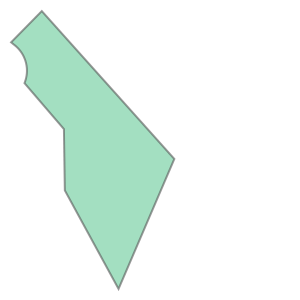

In [19]:
areas = geoms_from_shapefile("area.shp")
areas[0]

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

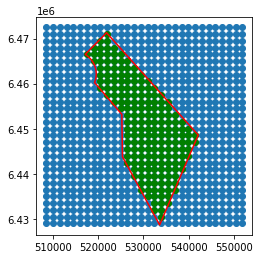

In [20]:
fig, ax = plt.subplots()

grid = Grid(n_rows=30, n_cols=30, scale=250, origin=(areas[0].centroid.x, areas[0].centroid.y))
layout = Layout(grid, areas=areas)
grid.plot(ax=ax)
layout.plot(ax=ax)

.. tip::
    You can pass an existing matlotlib axes to the plot methods in order to plot layouts and grids on the same existing axes.

If we now inspect the `area` attribute of the `Layout`, we can see that it now stores the information about this constraint.

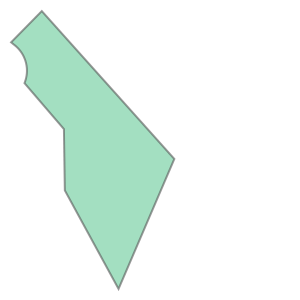

In [21]:
layout.area

### 2.2. Avoiding Exclusion Areas
Just like with buildable areas, im many projects you usually have to avoid placing turbines in specific areas for many different reasons such as existing
seabed or surface infrastructure, reefs, shipping lanes, etc.

The `Layout` object can also help you with this type of constraint via its `exclusion` attribute. Again, lets load some complex exclusion data from a shapefile and
include it as a constraint to the `Layout` object we created previously.

{'n_rows': 30, 'n_cols': 30, 'row_step': 6, 'col_step': 6, 'row_offset': False, 'col_offset': False, 'angle': 0, 'x_shear': None, 'y_shear': None, 'origin': (530189.1819029324, 6450750.151539923), 'scale': 250}


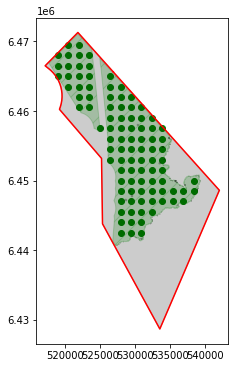

In [22]:
exclusions = geoms_from_shapefile("exclusions.shp")
layout.avoid_exclusions(exclusions)
layout.plot()
print(layout.grid)

.. tip:: If you forget the properties of the underlying `Grid` of a `Layout` instance (if the `Layout` was created from a grid) you can access the `Grid` properties using the
`grid` property of the `Layout` instance.

Just like with the `area` attribute, the `exclusion` attribute stores the exclusion information within the `Layout` instance.

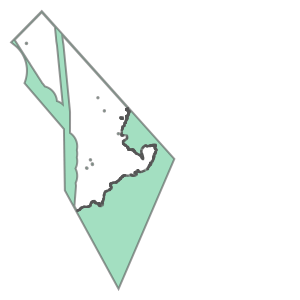

In [23]:
layout.exclusion

.. note:: Exclusions can also be applied when initialising a `Layout` by passing the exclusion geometries to the `exclusions` argument, just like the `areas` argument
in the Buildable Area example. Likewise, areas can be passed into an existing layout using the `clip_to_area` method.

### 2.3. Applying Bathymetry Constraints
In some cases, the bathymetry of a project area will be complex, and may have regions which are unsuitable for turbine placement because the water depths
at those locations fall outside of the design limits of the selected foundations types. Therefore, it is desireable to avoid these areas.

Typically, we are provided bathymetry/elevation data in a raster format, which is inherently very different to the vector data format that we have used until
now for `area` and `exclusion` operations, and therefore has to be treated differently. Instead of defining Points, Lines, or Polygons, raster data stores data
as a regular grid of georeferenced pixels, each with a height and width in space, and values stored in these pixels in one or more bands.

One may wish to pre-process this raster data in a separate GIS environment in order to convert the areas we wish to avoid into Polygons, and then pass them as additional
exclusion constraints to the `avoid_exclusions` method. However, the `Layout` object has the capability to read the original raster data directly and apply the desired constraints.
Let's use the `load_bathymetry` method and specify that water depths must be between 0m and 55m.


(<Figure size 576x432 with 2 Axes>, <AxesSubplot:>)

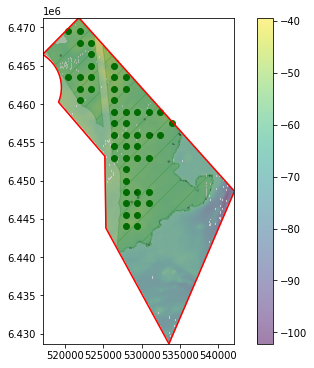

In [25]:
layout.load_bathymetry("bathymetry.tif", limits=(0, 55))
layout.plot(show_bathy=True)

We can see that some turbine positions have been lost as they were placed by the `Grid` in water depths beyond 55m.

.. important:: There is another similar method called `apply_bathymetry`. This method differs from `load_bathymetry` in
that it takes an already open bathymetry dataset, whereas `load_bathymetry` opens and closes the dataset. `apply_bathymetry`
has been designed for use within loops to eliminate the overhead of opening an closing the bathymetry dataset within each loop iteration.
Please see the API documentation for these methods for examples on how to use them.

## 3. Creating a `Layout` From Other Sources
So far, we have seen how to create a `Layout` from a `Grid`. What if we already have an existing dataset, and we want to load it into a `Layout` object for further analysis?
The `Layout` object comes equipped with class methods that allow us to construct an instance from alternative data sources.

A `Layout` can be created from:

- Shapefile (must contain Point or MultiPoint geometries)
- Text (.txt, .csv, etc.)
- PostGIS (Table must only contain Point or MultiPoint geometries)

### 3.1. Creating a `Layout` From a Shapefile
We can create a `Layout` from an ESRI Shapefile using the `from_shapefile` class method.

(<Figure size 576x432 with 1 Axes>, <AxesSubplot:>)

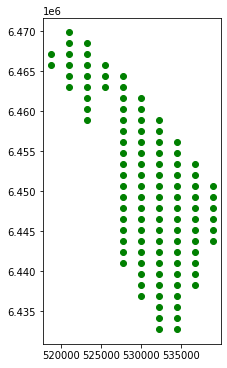

In [26]:
layout = Layout.from_shapefile("layout.shp")
layout.plot()

### 3.2. Creating a `Layout` From Text
We can create a `Layout` from a text file using the `from_text` method.

 .. note:: The default delimiter is set to ','. For different separators, the argument `sep` must be passed.
 For a teb delimited file, we would use `sep="\t"`.

(<Figure size 576x432 with 1 Axes>, <AxesSubplot:>)

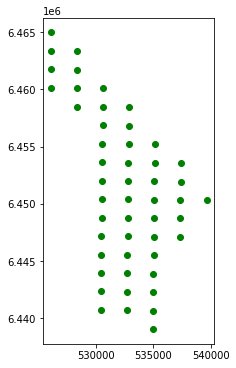

In [29]:
layout = Layout.from_text("text_layout.txt", x_header="X", y_header="Y", sep="\t")
layout.plot()

### 3.3. Creating a `Layout` From PostGIS
We can create a `Layout` from an online PostGIS table using the `from_postgis` method.

(<Figure size 576x432 with 1 Axes>, <AxesSubplot:>)

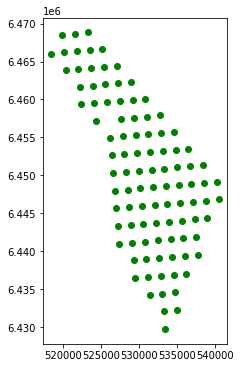

In [30]:
layout = Layout.from_postgis(username="name.surname@ow-postgre", 
                            password="***********",
                            schema="GB_CAL",
                            table="OW_LAYOUT_NGT260_20_100_001")
layout.plot()

## 4. Dealing With Coordinate Reference Systems
The `Layout` class takes care of most of the geospatial tasks commonly carried out by GIS software. When working with any geospatial data,
keeping track of the Coordinate Reference System, or CRS, is crucial. A CRS is a method of associating numerical coordinates with a position on the surface of the Earth.
The same x,y coordinates in a different CRS will represent different positions on the Earth. For the geospatial operations provided by the `Layout` class to work
as intended, the CRS of all data (grid coordinates, areas, exclusions, bathymetry) must be the same.

The `Layout` class offers support for thousands of standard CRSs based on the European Petroleum Searh Group ([EPSG](https://epsg.io/)) database, through the underlying
[Proj](https://proj.org/) library (same library that provides CRS funcionality to many GIS desktop applications such as QGIS).

Commonly, these standard EPSG projections are identified through use of an integer code which is a unique number associated with a specific CRS. For instance, the
common WGS 84 latitude/longitude CRS is known by the identifier EPSG:4326 (code 4326).

The following methods and functions allow re-projection of the source data on-the-fly to a user specified CRS using an EPSG code:

- `Layout.from_shapefile`
- `Layout.from_postgis`
- `Layout.from_text` (text files do not carry any projection information, so this method also accepts a source_epsg argument in order to correctly calculate the transformation)
- `geoms_from_shapefile`
- `geoms_from_postgis`

Let's take the following example, where we want to take a PostGIS table containing a project lease area stored with a WGS84 (EPSG:4326) CRS and convert it to UTM 30N (EPSG:32630).
First we will load the data in its source CRS without any transformations, and then repeat the process with a target_epsg.

POINT (-2.486717708510662 58.197103111498194)


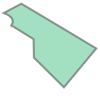

In [42]:
from layowt.layouts import geoms_from_postgis

areas = geoms_from_postgis(username="name.surname@ow-postgre", 
                            password="***********",
                            db_name="proj_uk_caledonia",
                            schema="offshore",
                            table="OW|Caledonia_OWF_Project_Boundary")

print(areas[0].centroid)
areas[0]

POINT (530189.1819029324 6450750.151539923)


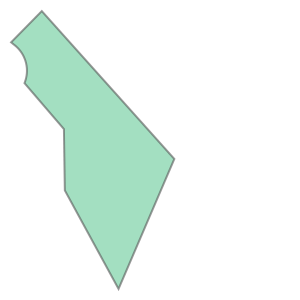

In [43]:
areas = geoms_from_postgis(username="name.surname@ow-postgre", 
                            password="***********",
                            db_name="proj_uk_caledonia",
                            schema="offshore",
                            table="OW|Caledonia_OWF_Project_Boundary",
                            target_epsg=32630)

print(areas[0].centroid)
areas[0]

### 4.1. Raster CRS
Reprojecting raster datasets is usually a *bad thing* to do. It involves a non-reversible transformation from one grid system to another grid system
that can have a non-linear relationship to the first. Hence, the value in a cell of the new system can end up being some average of whichever grid
cells in he source raster it overlapped.

In order for vector and raster data to work together, and carry out operations between them, they must be in the same coordinate reference system.
Consider the following *giudelines* when working toigether with vector and raster data:

- If you have raster and vector data in the same coordinate reference system, work with that.
- If you have a raster and vector data in different coordinate reference systems, reproject the vector data to the raster coordinate reference system
(since that is a precise and reversible transformation with no loss of information).
- *Only* if you have two rasters with different coordinate reference systems and you want to do some kind of operation between them, then you should
think about reprojecting one of them. 

`LayOWt` comes with a utility function to reproject raster dataset, but it is recommended to use with caution. The function `reproject_raster` can
be found in the `layowt.layouts` module.